In [1]:
import pandas as pd

train_log_path = './Out/20250526_172758/ray_train_log.csv'
train_log_data = pd.read_csv(train_log_path)

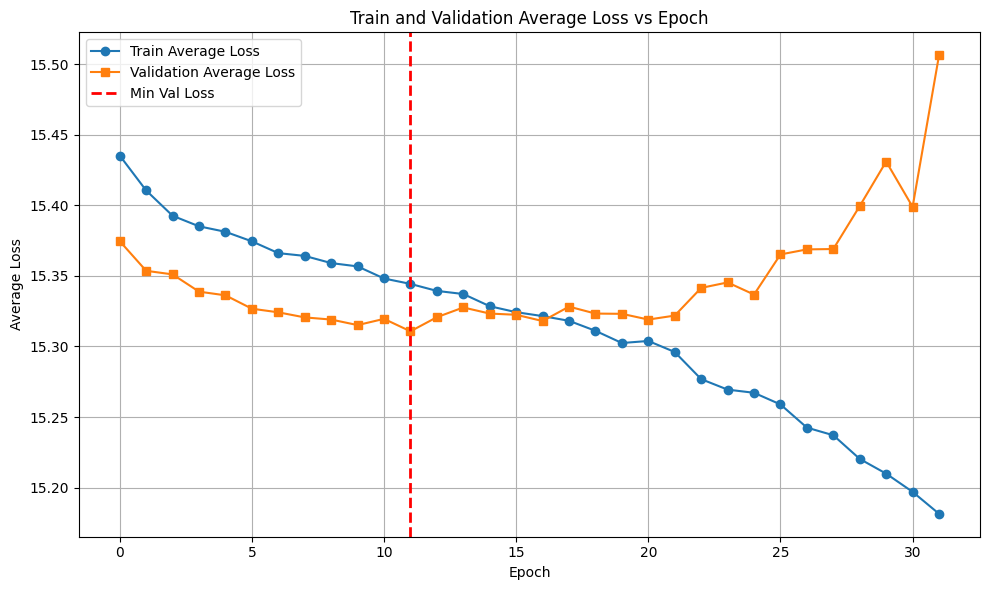

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(
    train_log_data["epoch"],
    train_log_data["train_average_loss"],
    label="Train Average Loss",
    marker="o",
)
plt.plot(
    train_log_data["epoch"],
    train_log_data["val_average_loss"],
    label="Validation Average Loss",
    marker="s",
)

min_val_loss_epoch = train_log_data.loc[train_log_data["val_average_loss"].idxmin()][
    "epoch"
]
plt.axvline(
    x=min_val_loss_epoch, color="r", linestyle="--", linewidth=2, label="Min Val Loss"
)


plt.title("Train and Validation Average Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

---

In [3]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    roc_auc_score,
)
from model import RnnModel
from utils import collate_fn
from model import mroRnnDataset

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from utils import create_train_test_group
import pandas as pd


# Check if CUDA (NVIDIA GPU) is available
if torch.cuda.is_available():
    # Get the number of available CUDA devices
    num_gpus = torch.cuda.device_count()
    print(f"Number of CUDA devices available: {num_gpus}")
    # Select a specific GPU (e.g., GPU 0)
    device = torch.device("cuda:6")  # Use "cuda:1" for GPU 1, etc.
    print(f"Using device: {torch.cuda.get_device_name(device)}")

Number of CUDA devices available: 10
Using device: NVIDIA GeForce RTX 2080 Ti


In [4]:
# ---------------------------------------------------------
# data preprocessing control parameter
sample_frac = 1
test_size = 0.1
valid_size = 0.1
max_seq_length = 8
batch_size = 4096
num_workers = 16

learning_rate = 0.0005
num_epochs = 1000

# ---------------------------------------------------------
# Parameters for RNN Model
rnn_type = "LSTM"
rnn_output_size = 128
bidirectional = True
# pooling_method value =  None, 'max', 'avg', 'attention', 'multihead_attention'
num_layers = 2
pooling_method = None
num_heads = None
use_last_hidden = True
agg_fun = ["mean", "sum", "max", "min", "std", "skew"]

# ---------------------------------------------------------
file_name = "./Data/mro_daily_clean.csv"
data = pd.read_csv(file_name, index_col=0, engine="pyarrow")

In [5]:
# ---------------------------------------------------------
continuous_variable = [
    "hard_braking",
    "hard_acceleration",
    "speeding_sum",
    "day_mileage",
    "engn_size",
    "est_hh_incm_prmr_cd",
    "purchaser_age_at_tm_of_purch",
    "tavg",
    "random_avg_traffic",
]

category_variable = [
    "gmqualty_model",
    "umf_xref_finc_gbl_trim",
    "input_indiv_gndr_prmr_cd",
]

driver_navigation = [
    "id",
    "yr_nbr",
    "mth_nbr",
    "week_nbr",
]

mro = ["mro"]
data = data[driver_navigation + continuous_variable + category_variable + mro]
data = data.groupby(["id", "yr_nbr", "week_nbr"]).agg(
    {
        "mth_nbr": "first",
        "mro": "max",
        "hard_braking": agg_fun,
        "hard_acceleration": agg_fun,
        "speeding_sum": agg_fun,
        "day_mileage": agg_fun,
        "est_hh_incm_prmr_cd": "first",
        "purchaser_age_at_tm_of_purch": "first",
        "input_indiv_gndr_prmr_cd": "first",
        "gmqualty_model": "first",
        "umf_xref_finc_gbl_trim": "first",
        "engn_size": "first",
        "tavg": agg_fun,
        "random_avg_traffic": agg_fun,
    }
)

data.reset_index(inplace=True)


def flatten_columns(df: pd.DataFrame):
    def clean_col(col):
        if isinstance(col, tuple):
            col_name, agg_func = col
            agg_func = agg_func.strip()
            if col_name in mro and agg_func == "max":
                return "mro"
            if agg_func in ("first", ""):
                return col_name
            return f"{col_name}_{agg_func}"
        else:
            return col

    df.columns = [clean_col(col) for col in df.columns]
    return df


data = flatten_columns(data)
data.fillna(0, inplace=True)
data = data.drop(["yr_nbr", "week_nbr", "mth_nbr"], axis=1)


col_need_std = [
    item
    for item in data.columns.values.tolist()
    if item not in (mro + ["id"] + category_variable)
]

col_need_encode = category_variable


scaler = StandardScaler()
data[col_need_std] = scaler.fit_transform(data[col_need_std])


encoder = OneHotEncoder(sparse_output=False)
encoded_categorical = encoder.fit_transform(data[col_need_encode])

category_counts = [len(encoder.categories_[i]) for i, _ in enumerate(col_need_encode)]

onehot_feature_names = []
for col_idx, col in enumerate(col_need_encode):
    num_categories = category_counts[col_idx]
    onehot_feature_names.extend([f"{col}_onehot_{i}" for i in range(num_categories)])

encoded_df = pd.DataFrame(
    encoded_categorical, index=data.index, columns=onehot_feature_names
)
data = pd.concat([data, encoded_df], axis=1)


rnn_features = col_need_std + onehot_feature_names
# col_rnn_origin = ["id"] + rnn_features + ["mro"]
col_rnn_origin = ["id"] + rnn_features + mro
data_rnn_origin = data[col_rnn_origin].copy()
data_rnn_origin = create_train_test_group(
    data_rnn_origin,
    sample_frac=sample_frac,
    test_size=test_size,
    valid_size=valid_size,
    random_state=42,
)


# rnn_target = ["mro"]
rnn_target = mro


# ---------------------------------------------------------
test_data_set = mroRnnDataset(
    data_rnn_origin=data_rnn_origin,
    rnn_features=rnn_features,
    rnn_target=rnn_target,
    group="test",
    max_seq_length=max_seq_length,
)


input_feature_size = len(rnn_features)
output_size = len(rnn_target)

In [6]:
from model import FocalLoss
alpha = 1 - data_rnn_origin["mro"].eq(1).mean()
print(f"Alpha value for Focal Loss: {alpha}")
gamma = 4
print(f"Gamma value for Focal Loss: {gamma}")
criterion = FocalLoss(alpha=alpha, gamma=gamma).to(device)

Alpha value for Focal Loss: 0.9523861793110602
Gamma value for Focal Loss: 4


In [7]:
# model init
model = RnnModel(
    rnn_type=rnn_type,
    input_size=input_feature_size,
    rnn_output_size=rnn_output_size,
    output_size=output_size,
    bidirectional=bidirectional,
    num_layers=num_layers,
    pooling_method=pooling_method,
    num_heads=num_heads,
    use_last_hidden=use_last_hidden,
)

In [8]:
model_path = "./Out/20250526_172758/model.pt"
state_dict = torch.load(model_path)

# remove the prefix with model .
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] if k.startswith('module.') else k  # remove 'module.'
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)
model.eval()
# model.to("cuda" if torch.cuda.is_available() else "cpu")
# model.to("cpu")
model.to(device)

RnnModel(
  (rnn): LSTM(74, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [9]:
test_loader = DataLoader(
    test_data_set,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=16,
)


all_test_mro_preds = []
all_test_mro_targets = []
all_test_mro_scores = []
test_running_loss = 0.0

with torch.no_grad():
    for test_inputs, test_targets, test_lengths in test_loader:
        test_inputs = test_inputs[:, :-1, :].to(device)
        test_targets = test_targets.to(device)
        test_lengths = test_lengths.to("cpu")

        # forward
        model_out = model(test_inputs, test_lengths)

        # calculate the loss
        loss = criterion(model_out, test_targets[:, -1, :])
        test_running_loss += loss.item()

        # get the predicted result
        mro_pred = torch.sigmoid(model_out)
        mro_preds = (mro_pred > 0.5).int().cpu().numpy().flatten()
        mro_targets = test_targets[:, -1, :].cpu().numpy().flatten()

        all_test_mro_preds.extend(mro_preds)
        all_test_mro_targets.extend(mro_targets)
        all_test_mro_scores.extend(mro_pred.cpu().numpy().flatten())


test_average_loss = test_running_loss / (len(test_loader) / batch_size)
test_f1 = f1_score(all_test_mro_targets, all_test_mro_preds)
test_accuracy = accuracy_score(all_test_mro_targets, all_test_mro_preds)
test_recall = recall_score(all_test_mro_targets, all_test_mro_preds)
test_precision = precision_score(all_test_mro_targets, all_test_mro_preds)
test_auc = roc_auc_score(all_test_mro_targets, all_test_mro_scores)

In [10]:
metrics = {
    "experiment_name": "LSTM_full_feature_full_mro",
    "test_average_loss": test_average_loss,
    "test_f1": test_f1,
    "test_accuracy": test_accuracy,
    "test_recall": test_recall,
    "test_precision": test_precision,
    "test_auc": test_auc,
}

metrics

{'experiment_name': 'LSTM_full_feature_full_mro',
 'test_average_loss': 15.439258450553531,
 'test_f1': 0.10120623712856723,
 'test_accuracy': 0.6351261204312477,
 'test_recall': 0.4612466479168029,
 'test_precision': 0.05683888127669864,
 'test_auc': np.float64(0.5749347909281405)}

In [11]:
import os

experiment_result_folder = './Out'
os.makedirs(os.path.dirname(experiment_result_folder), exist_ok=True)

experiment_result_path = './Out/experiment_metrics.csv'
df = pd.DataFrame([metrics])
write_header = not os.path.exists(experiment_result_path)
df.to_csv(experiment_result_path, mode="a", header=write_header, index=False)

---

## Permutation Importance

In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np


all_inputs = []
all_targets = []

with torch.no_grad():
    for inputs, targets, lengths in test_loader:
        all_inputs.append(inputs)
        all_targets.append(targets)
        if len(all_inputs) > 10:
            break

X_test = torch.cat(all_inputs, dim=0)  # shape: [num_samples, seq_len, input_dim]
y_test = (
    torch.cat(all_targets, dim=0)[:, -1, :].cpu().numpy().flatten()
)  # shape: [num_samples]


def compute_auc(model, X, y, device):
    model.eval()
    with torch.no_grad():
        inputs_tensor = X.to(device)
        lengths = torch.tensor([X.size(1)] * X.size(0))
        outputs = model(inputs_tensor, lengths)
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()
    return roc_auc_score(y, probs)


def permutation_importance_lstm(
    model, X, y, feature_names, device, metric_func=compute_auc
):
    baseline_auc = metric_func(model, X, y, device)
    importances = {}

    X_np = X.cpu().numpy()

    for i, feat_name in enumerate(feature_names):
        X_shuffle = X_np.copy()
        for t in range(X_shuffle.shape[1]):
            np.random.shuffle(X_shuffle[:, t, i])

        X_shuffled_tensor = torch.tensor(X_shuffle, dtype=X.dtype, device=device)
        shuffled_auc = metric_func(model, X_shuffled_tensor, y, device)
        importance = baseline_auc - shuffled_auc
        importances[feat_name] = importance

    return importances


feature_names = rnn_features
importances = permutation_importance_lstm(model, X_test, y_test, feature_names, device)


sorted_importances = sorted(importances.items(), key=lambda x: abs(x[1]), reverse=True)

print("Feature Importances (Permutation Importance):")
for name, score in sorted_importances:
    print(f"{name}: {score:.6f}")

Feature Importances (Permutation Importance):
tavg_sum: 0.011137
day_mileage_mean: 0.008205
engn_size: 0.006541
day_mileage_max: 0.004470
speeding_sum_sum: 0.004289
speeding_sum_min: 0.004269
hard_acceleration_min: 0.004195
hard_braking_min: 0.003954
random_avg_traffic_sum: 0.003614
tavg_std: 0.003570
hard_braking_skew: 0.003431
hard_braking_std: 0.002597
day_mileage_sum: 0.002279
tavg_max: 0.001766
day_mileage_skew: 0.001732
speeding_sum_mean: 0.001685
umf_xref_finc_gbl_trim_onehot_6: 0.001666
gmqualty_model_onehot_22: -0.001511
hard_acceleration_mean: 0.001508
random_avg_traffic_std: -0.001405
random_avg_traffic_skew: -0.001266
day_mileage_min: -0.001152
speeding_sum_skew: -0.001151
speeding_sum_max: 0.001144
hard_acceleration_sum: 0.001085
tavg_min: -0.001047
hard_acceleration_std: 0.001045
random_avg_traffic_min: 0.001019
hard_braking_mean: -0.000984
hard_acceleration_skew: 0.000958
input_indiv_gndr_prmr_cd_onehot_1: -0.000837
purchaser_age_at_tm_of_purch: 0.000743
hard_acceleratio

In [16]:
from collections import defaultdict

# original features
raw_features = [
    "hard_braking",
    "hard_acceleration",
    "speeding_sum",
    "day_mileage",
    "est_hh_incm_prmr_cd",
    "purchaser_age_at_tm_of_purch",
    "input_indiv_gndr_prmr_cd",
    "gmqualty_model",
    "umf_xref_finc_gbl_trim",
    "engn_size",
    "tavg",
    "random_avg_traffic",
]

# transfer sorted_importances to dict
importances_dict = dict(sorted_importances)
grouped_importances = {}

for raw_feat in raw_features:
    matched = []
    for feat, imp in importances_dict.items():
        if feat.startswith(raw_feat):
            matched.append(imp)
    if len(matched) > 0:
        avg_imp = sum(matched) / len(matched)
    else:
        avg_imp = 0.0
    
    grouped_importances[raw_feat] = avg_imp
sorted_grouped = sorted(grouped_importances.items(), key=lambda x: abs(x[1]), reverse=True)

print("Grouped & Averaged Feature Importances:")
for name, score in sorted_grouped:
    print(f"{name}: {score:.6f}")

Grouped & Averaged Feature Importances:
engn_size: 0.006541
day_mileage: 0.002639
tavg: 0.002621
speeding_sum: 0.001667
hard_acceleration: 0.001555
hard_braking: 0.001542
purchaser_age_at_tm_of_purch: 0.000743
est_hh_incm_prmr_cd: 0.000385
random_avg_traffic: 0.000294
umf_xref_finc_gbl_trim: 0.000228
input_indiv_gndr_prmr_cd: -0.000223
gmqualty_model: -0.000076


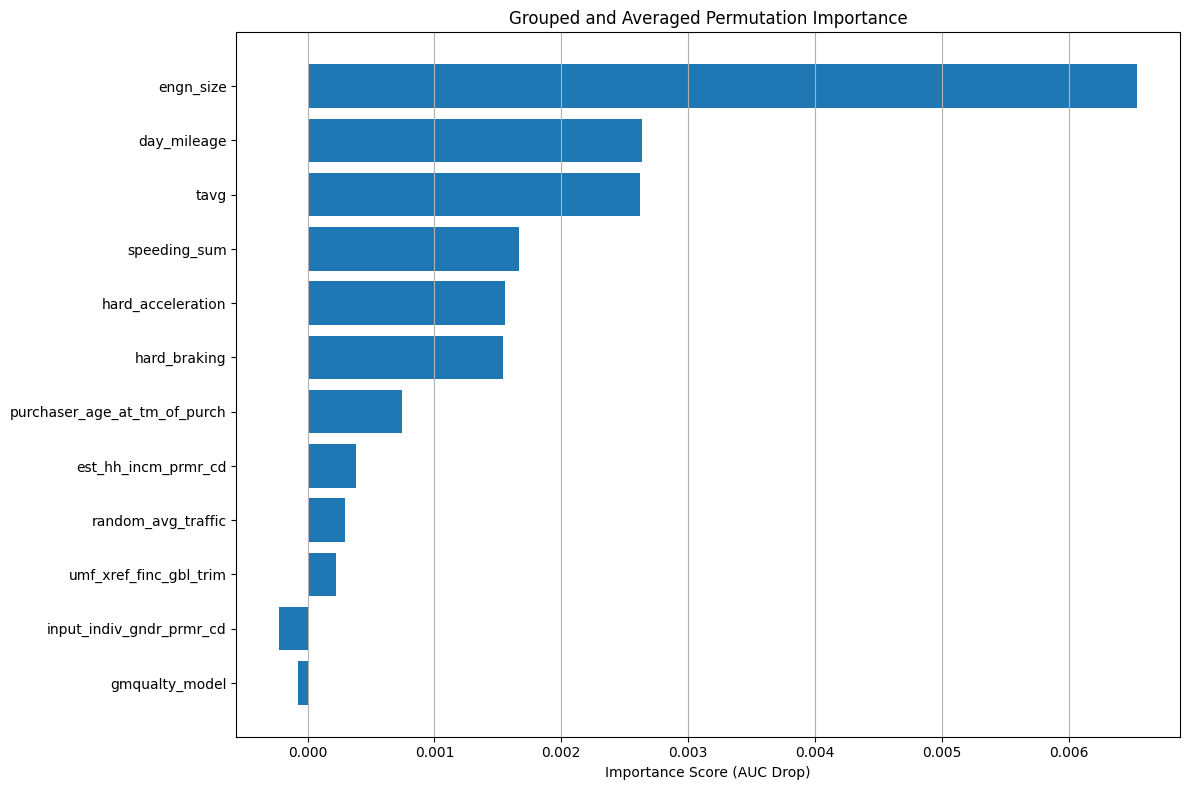

In [17]:
features, scores = zip(*sorted_grouped)

plt.figure(figsize=(12, 8))
plt.barh(features, scores)
plt.xlabel('Importance Score (AUC Drop)')
plt.title('Grouped and Averaged Permutation Importance')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.tight_layout()
plt.show()